In [1]:
# https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook

In [2]:
!pip install jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp
from flax import linen as nn
from jax import random
import optax
import flax
import time
from typing import Sequence
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt


In [4]:
data_dir = '/tmp/tfds'

mnist_data, info = tfds.load(name="mnist", data_dir=data_dir, batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
h, w, c = info.features['image'].shape
num_pixels = h * w * c

print(f'Numero de pixels:{num_pixels}')
print(f'h = {h}, w = {w}, c = {c}')

Numero de pixels:784
h = 28, w = 28, c = 1


In [6]:
# DATA 
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [7]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)


## **RNN**

In [8]:
## PARAMETROS
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10

In [9]:
class NaiveSequential(nn.Module):
    @nn.compact
    def __call__(self, inputs):
      x = inputs
      x = nn.Dense(512)(x)
      x = nn.relu(x)
      x = nn.Dense(10)(x)
      x = nn.softmax(x)
      return x

In [21]:
class RNN():
  def __init__(self,modelo,optimizer,params) -> None:
    self.model = modelo
    self.params = params
    self.optimizer = optimizer

  ## FUNÇÃO DE PERDA
  def loss(self,params, images, targets):
    preds = self.model.apply(params, images)
    return -jnp.mean(preds * targets)

  ## FUNÇÃO DE SCORE DE TREINAMENTO 
  def accuracy(self, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(self.model.apply(self.params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

  ## SEPARA OS DADOS DE TREINAMENTO E TESTE EM BATCHES
  def get_train_batches(self,x,y,batch_size):
    return zip(jnp.array_split(x,batch_size),jnp.array_split(y,batch_size))

  ## FUNÇÃO DE TREINAMENTO
  def train(self,num_epochs,train,test,num_labels,batch_size):
    opt_state = self.optimizer.init(self.params)
    for epoch in range(num_epochs):
      start_time = time.time()
      for x, y in self.get_train_batches(train[0],train[1],batch_size):
        grads = grad(self.loss)(self.params,x, y) # Gradiente
        updates, opt_state = self.optimizer.update(grads, opt_state) # Gera os novos parametros 
        self.params = optax.apply_updates(self.params, updates) # Executa a atualização dos paramestros

      epoch_time = time.time() - start_time
      
      train_acc = self.accuracy( train[0],train[1])
      test_acc = self.accuracy( test[0],test[1])
      print(f"Epoch {epoch} in {epoch_time:0.2f} sec -> Training set accuracy {train_acc} - Test set accuracy {test_acc}")
      
  ## FUNÇÃO PREDICT
  def predict(self,test_images):
    return self.model.apply(self.params, test_images)

In [24]:
# Model
dense = NaiveSequential()

# Params
params = dense.init(random.PRNGKey(0), train_images)

# Optmizer
optimizer = optax.sgd(1e-1,momentum=1.e-2,nesterov=True)

# Cal model
modelo = RNN(dense,optimizer,params)

# Train
modelo.train(num_epochs = 10,
             train =(train_images,train_labels),
             test = (test_images,test_labels),
             num_labels = num_labels,
             batch_size = batch_size
            )

Epoch 0 in 7.74 sec -> Training set accuracy 0.7553499937057495 - Test set accuracy 0.7604999542236328
Epoch 1 in 7.65 sec -> Training set accuracy 0.7971833348274231 - Test set accuracy 0.802899956703186
Epoch 2 in 8.15 sec -> Training set accuracy 0.8093000054359436 - Test set accuracy 0.8155999779701233
Epoch 3 in 8.21 sec -> Training set accuracy 0.8237000107765198 - Test set accuracy 0.8281999826431274
Epoch 4 in 7.20 sec -> Training set accuracy 0.8290500044822693 - Test set accuracy 0.8303999900817871
Epoch 5 in 8.17 sec -> Training set accuracy 0.8324999809265137 - Test set accuracy 0.8345999717712402
Epoch 6 in 8.18 sec -> Training set accuracy 0.8353666663169861 - Test set accuracy 0.8364999890327454
Epoch 7 in 7.21 sec -> Training set accuracy 0.8332499861717224 - Test set accuracy 0.8367999792098999
Epoch 8 in 7.70 sec -> Training set accuracy 0.838699996471405 - Test set accuracy 0.840399980545044
Epoch 9 in 8.87 sec -> Training set accuracy 0.8388833403587341 - Test set a

In [18]:
modelo.accuracy(test_images, test_labels)

Array(0.83769995, dtype=float32)

In [19]:
y_hat = modelo.predict(test_images)

In [20]:
for i in range(10):
  print(f"""Predict:{jnp.argmax(y_hat[i])} Label true:{jnp.argmax(test_labels[i])}""")

Predict:2 Label true:2
Predict:0 Label true:0
Predict:4 Label true:4
Predict:8 Label true:8
Predict:7 Label true:7
Predict:6 Label true:6
Predict:0 Label true:0
Predict:6 Label true:6
Predict:3 Label true:3
Predict:1 Label true:1


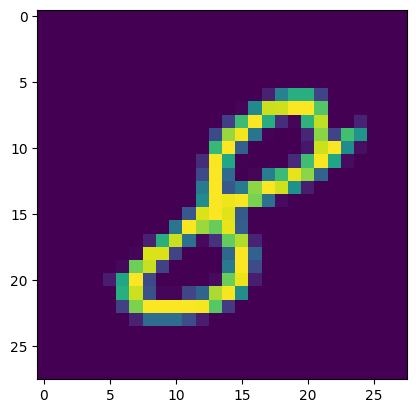

In [23]:
imgplot = plt.imshow(test_images[3].reshape(h, w, c))
plt.show()